# MLB Stats Project 
## Examining variables' effect on Major League Basball game's run totals 

First, let's import necessary libraries and import our data

In [1]:
import query_helper
import pandas as pd 
import charlie_functions
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [40]:
df = pd.read_csv('/Users/schlinkertc/Flatiron/projects/MLB_Stats/MLB_Data.csv',index_col=0)
df['game_date'] = df['game_date'].map(lambda x:pd.to_datetime(x))

Our data has 11 columns and about 26,000 rows. It represents every completed regular season MLB game in the last 10 years.

In [46]:
display(df.head())
df.shape

,gameid,run_total,venue_name,home_team,away_team,game_date,status,temp,weather_category,division,league
0,244193,5,Citizens Bank Park,Philadelphia Phillies,Atlanta Braves,2009-04-05,Final,60,clear,NL_east,NL
1,244194,6,Minute Maid Park,Houston Astros,Chicago Cubs,2009-04-06,Final,66,roof closed,AL_west,AL
2,244195,10,Rangers Ballpark in Arlington,Texas Rangers,Cleveland Indians,2009-04-06,Final,49,sunny,AL_west,AL
3,244196,17,Chase Field,Arizona Diamondbacks,Colorado Rockies,2009-04-06,Final,80,roof closed,NL_west,NL
4,244197,17,Rogers Centre,Toronto Blue Jays,Detroit Tigers,2009-04-06,Final,68,roof closed,AL_east,AL


(26321, 11)

### Our first test compares the mean runs scored across the American League and National League 

Since 1973, the American League has allowed a Designated Hitter to bat in place of the pitcher. We want to determine if this makes a difference in runs scored per game. 

In [49]:
NL = df[df['league']=='NL']
AL = df[df['league']=='AL']

NL_runs = NL['run_total']
AL_runs = AL['run_total']

In [53]:
display(NL_runs.describe())
display(AL_runs.describe())

count    13174.000000
mean         8.612722
std          4.413306
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         30.000000
Name: run_total, dtype: float64

count    13147.000000
mean         9.012779
std          4.467761
min          1.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         32.000000
Name: run_total, dtype: float64

To examine the affect of the Designated Hitter on runs scored, we will employ a two-sample Z-Test. 

- Null Hypothesis: Population means for runs scored across both leagues are equal.
- Alt Hypothesis: Population means are not equal.

First, we plot the distribution of total runs per game for both leagues to get a sense of the data.

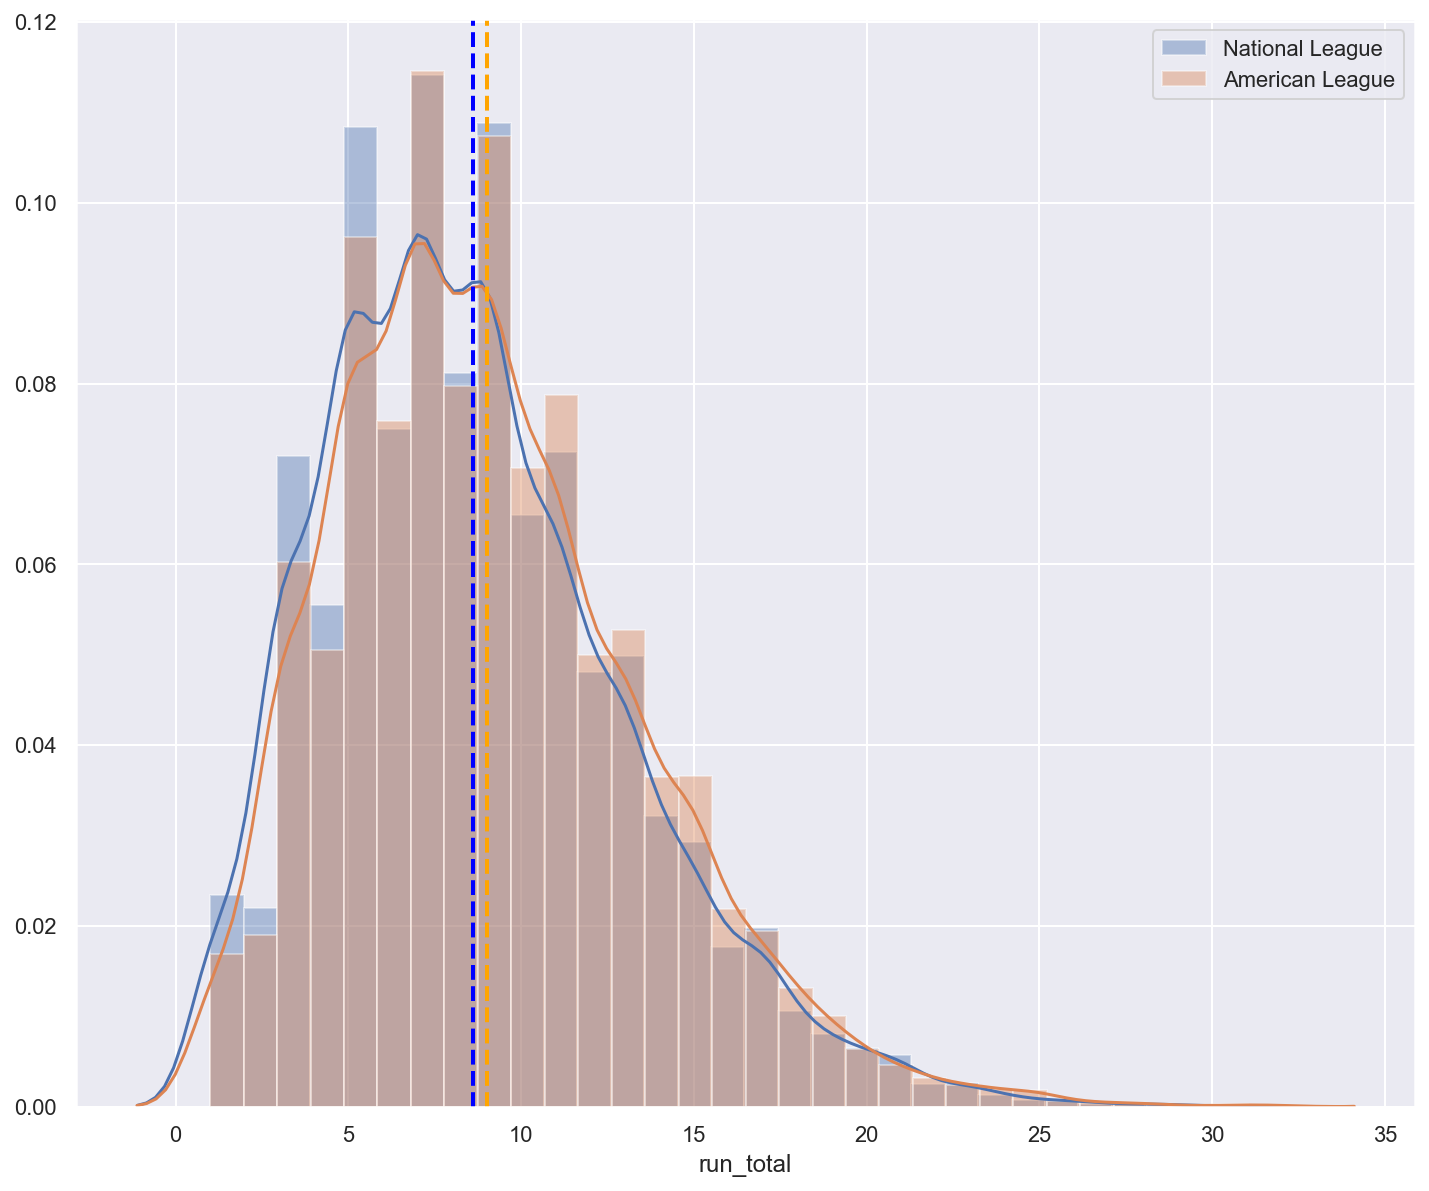

In [61]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(NL_runs,bins=NL_runs.max(),label='National League') # Blue distribution
sns.distplot(AL_runs,bins=AL_runs.max(),label='American League') # Orange distribution

plt.legend()

plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=2)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=2)

In [63]:
NL_skew = stats.skew(NL_runs)
AL_skew = stats.skew(AL_runs)
print(NL_skew,AL_skew)

0.7606128171412102 0.7540337783692563


By graphing the theoretical sampling distribution of means, we can visualize the Central Limit Theorum at play. This ultimately allows to perform our statistical analysis. 

In [12]:
NL_samples = [np.random.choice(NL_runs, replace=False, size=30) for i in range(len(NL_runs/30))]
AL_samples = [np.random.choice(AL_runs, replace=False, size=30) for i in range(len(AL_runs/30))]

NL_sampleMeans = [np.mean(i) for i in NL_samples]
AL_sampleMeans = [np.mean(i) for i in AL_samples]

Text(0.5, 0, 'Mean Runs Scored per Game')

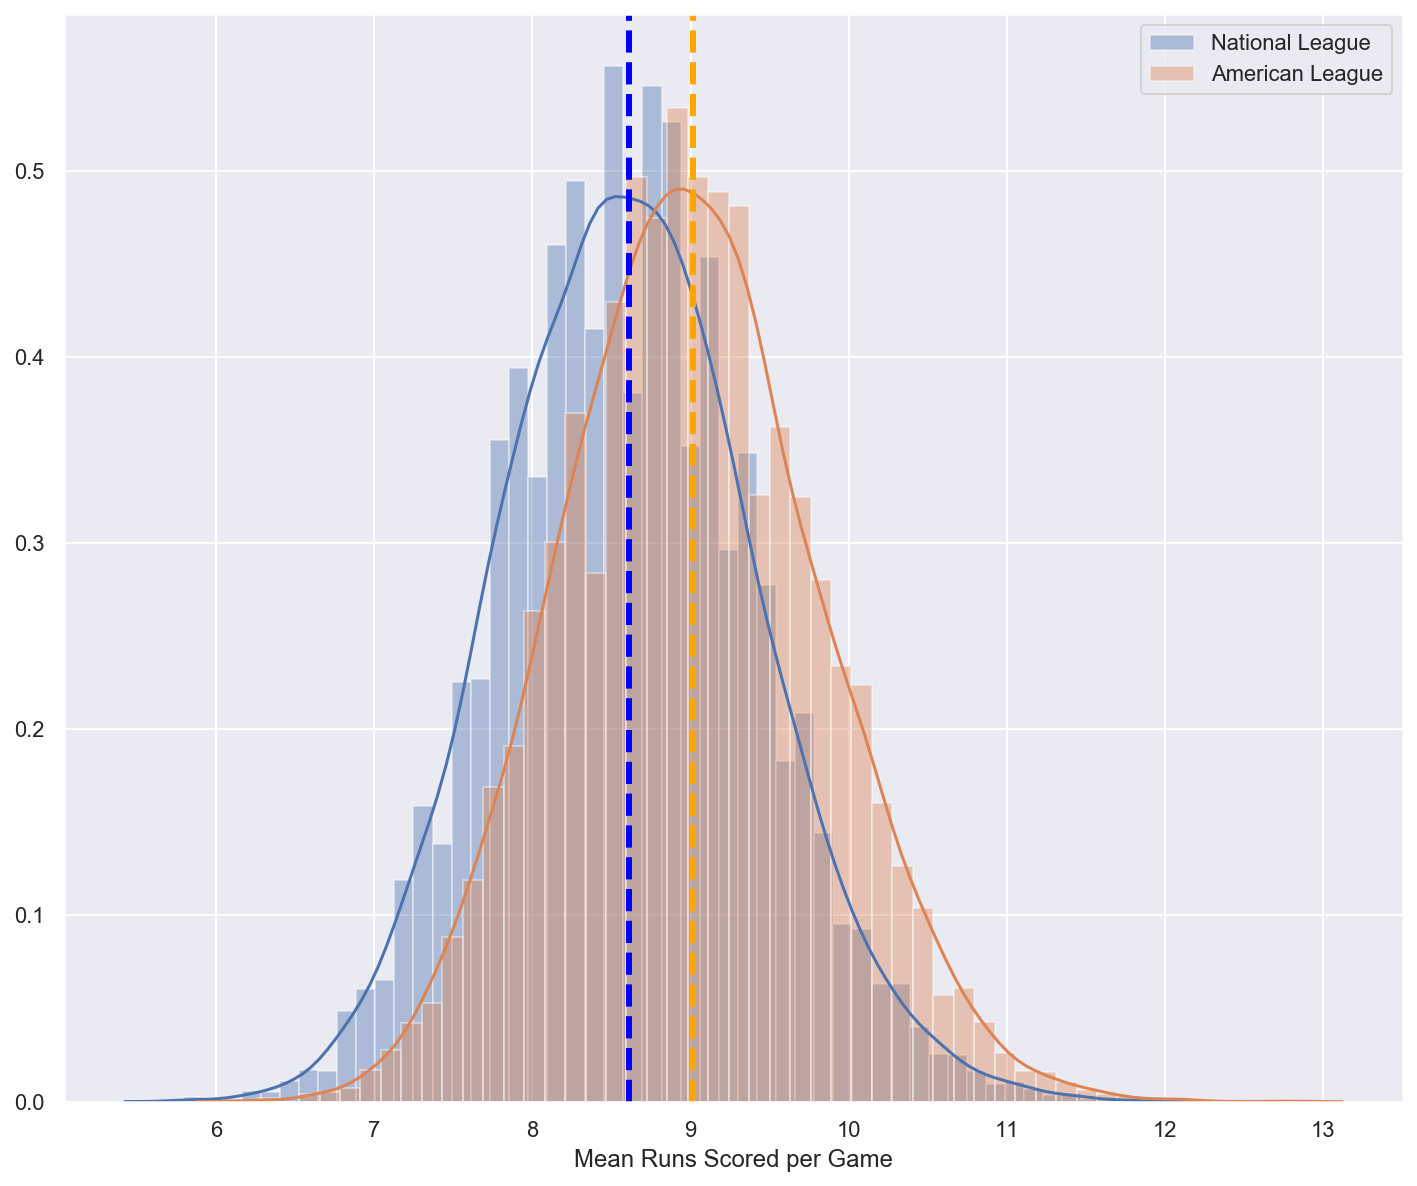

In [62]:
sns.distplot(NL_sampleMeans,label='National League')
sns.distplot(AL_sampleMeans,label='American League')

plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=3)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=3)

plt.legend()
plt.xlabel('Mean Runs Scored per Game')

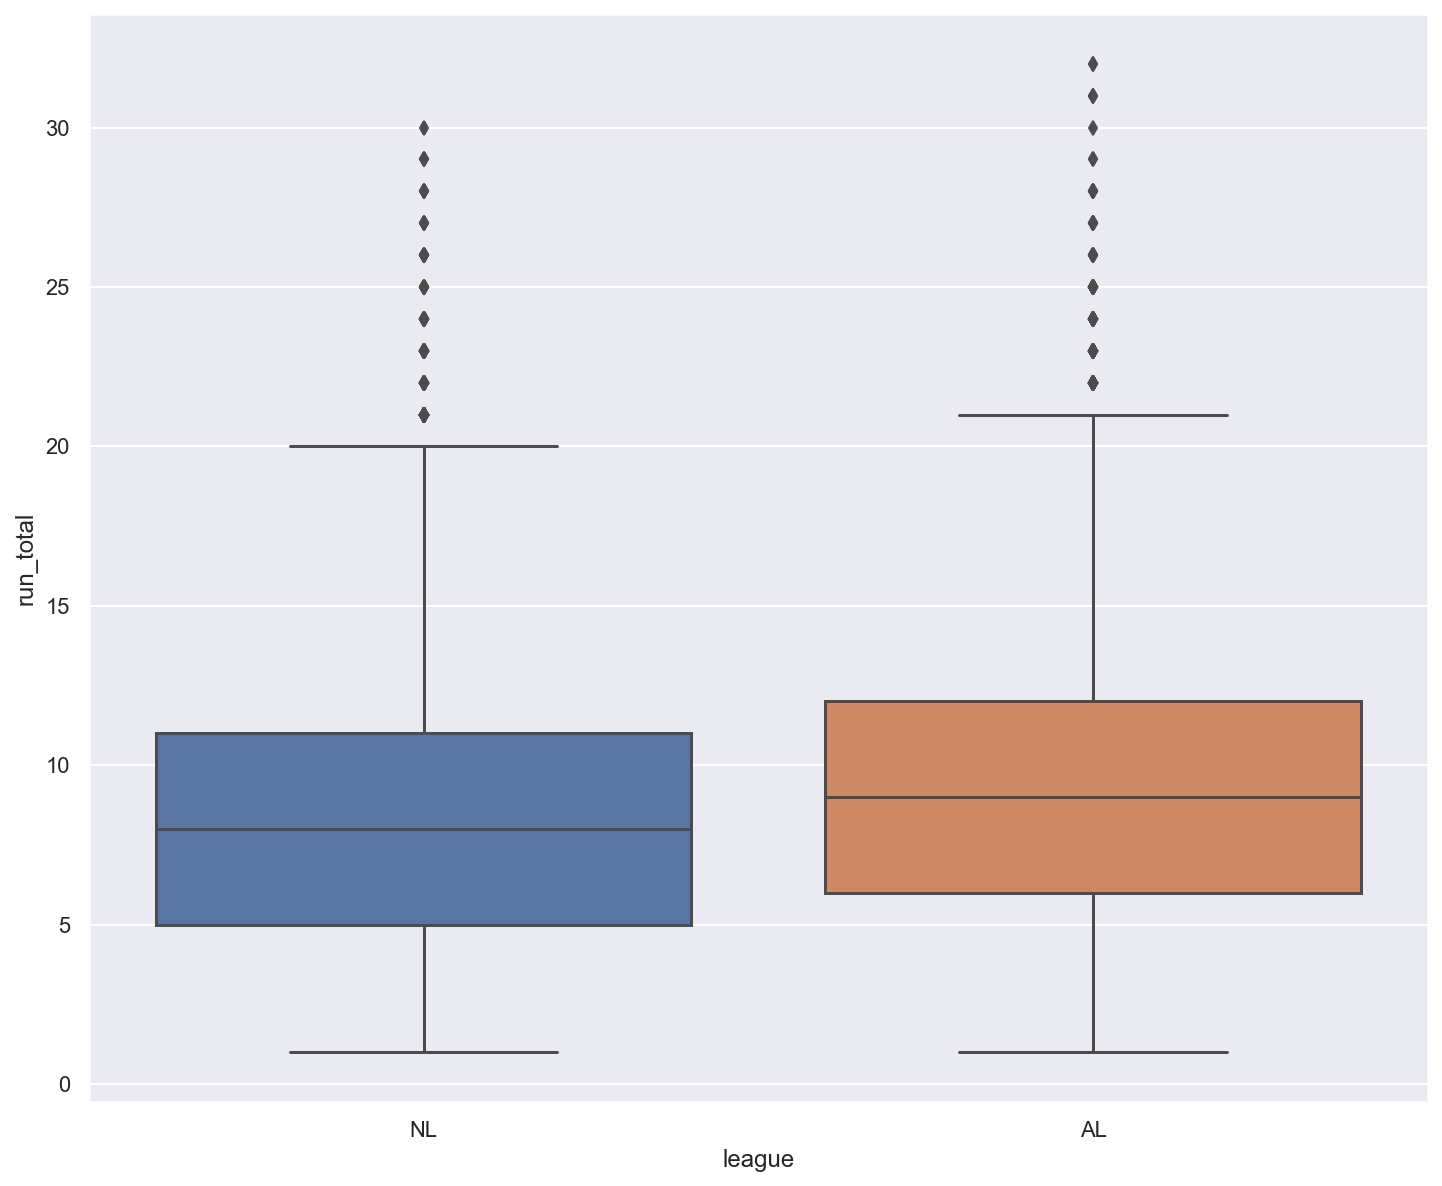

In [56]:
sns.boxplot(x=df['league'],y=df['run_total'],orient='v')


Now we calculate our Z statistic

In [64]:
AL_mean = np.mean(AL_runs)
NL_mean = np.mean(NL_runs)

NL_std = np.std(NL_runs)
AL_std = np.std(AL_runs)

NL_n = len(NL_runs)
AL_n = len(AL_runs)

numer = (AL_mean-NL_mean)
denom = np.sqrt((NL_std**2/NL_n)+(AL_std**2/AL_n))

print(numer,denom)

0.40005655242735294 0.05474047939554291


In [66]:
Z = numer/denom
Z

7.308239840879552

With a Z-Statisic of 7.3, our P-Value is less than our pre-determined alpha. Therefore, we may reject the null hypothesis.

In [68]:
P_value = 1-stats.norm.cdf(Z)
print(P_value)
alpha = .001
P_value < alpha

1.3533618670180658e-13


True

While our P-Value indicates that the population means are fundamentally different, the effect size as demonstrated by Cohen's D tells us that the magnitude of difference in population means is low.   

In [69]:
pooled_SD = np.sqrt((NL_std**2 + AL_std**2)/2)
cohens_d = (AL_mean - NL_mean)/pooled_SD
cohens_d

0.09009372728428088

### Our next hypothesis test will determine the effect of weather on runs scored per game

We initially planned to consider 'weather category' as provided by the MLB. 


In [24]:
#take out snow because it was only two games.
snow = df[df['weather_category']=='snow'].index
df.drop(snow,inplace=True)
snow

Int64Index([9734, 21649], dtype='int64')

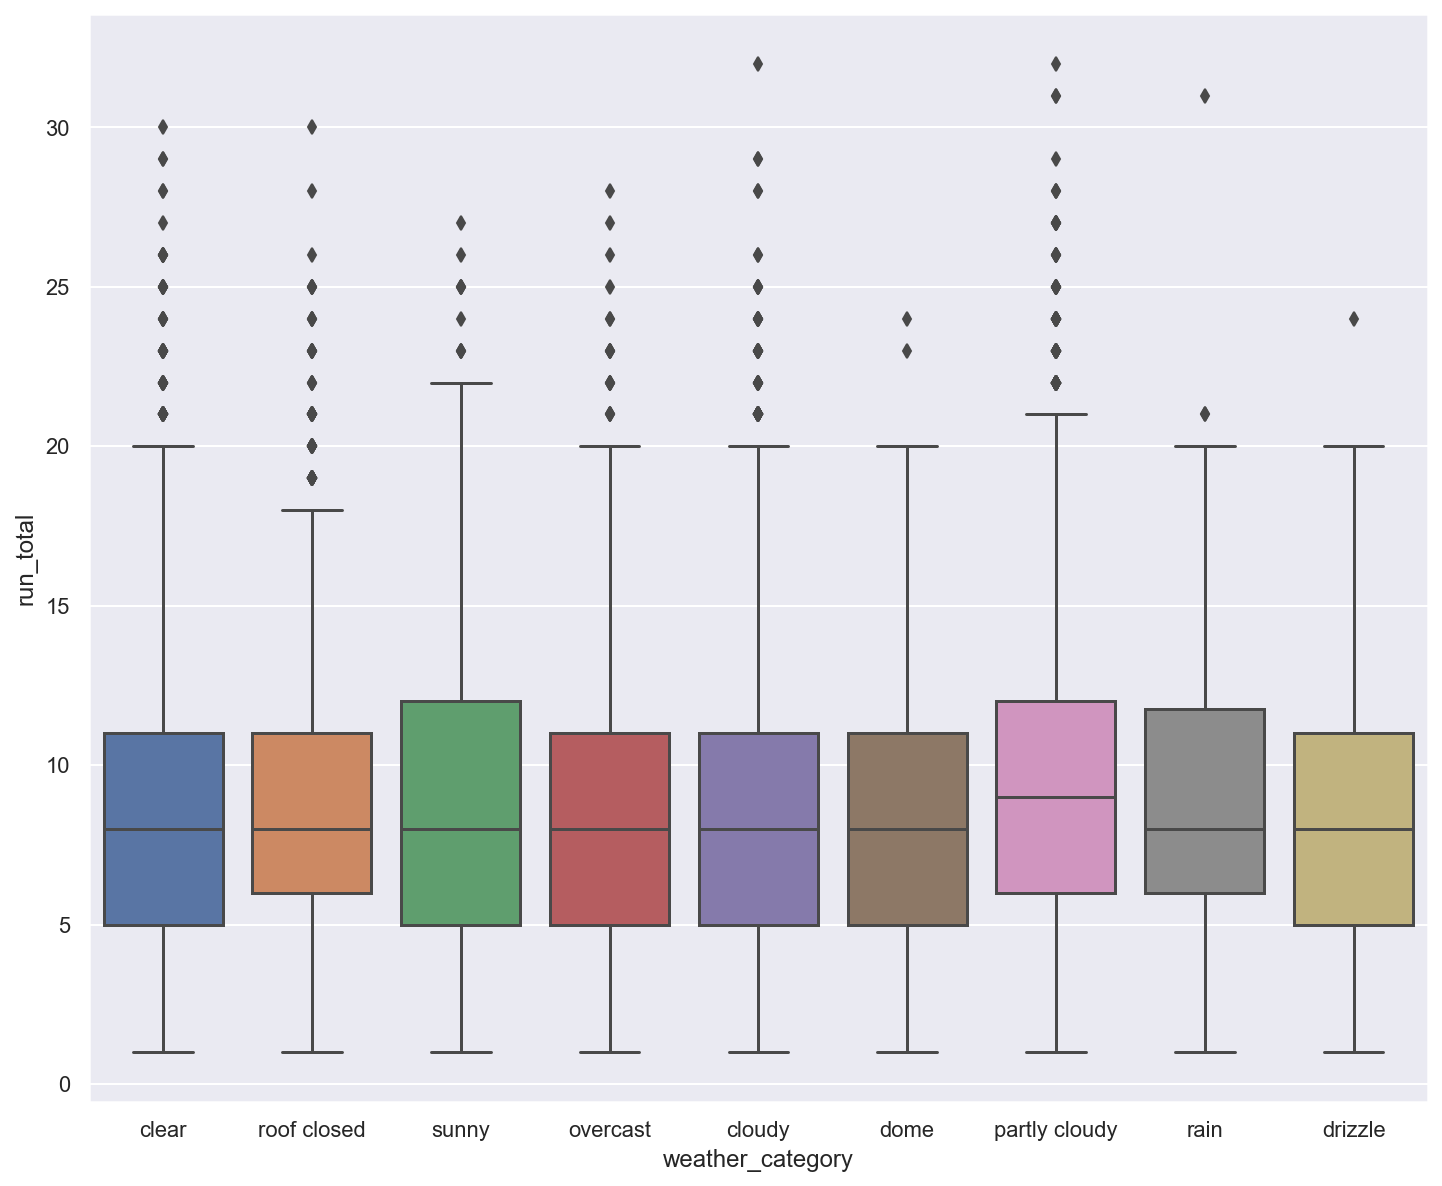

In [25]:
sns.boxplot(x=df['weather_category'],y=df['run_total'],orient='v')

In [71]:
conditions = list(df['weather_category'].unique())
games_per_condition = [(i,df[df['weather_category']==i].shape[0]) for i in conditions]
games_per_condition

[('clear', 5148),
 ('roof closed', 2711),
 ('sunny', 2580),
 ('overcast', 1573),
 ('cloudy', 4666),
 ('dome', 988),
 ('partly cloudy', 8324),
 ('rain', 142),
 ('drizzle', 187),
 ('snow', 2)]

#### We abandoned this analysis because weather would have a drastically different effect on games played during the day versus those played at night. 

We opted to examine the effect of temperature instead. This required correlation analysis. 

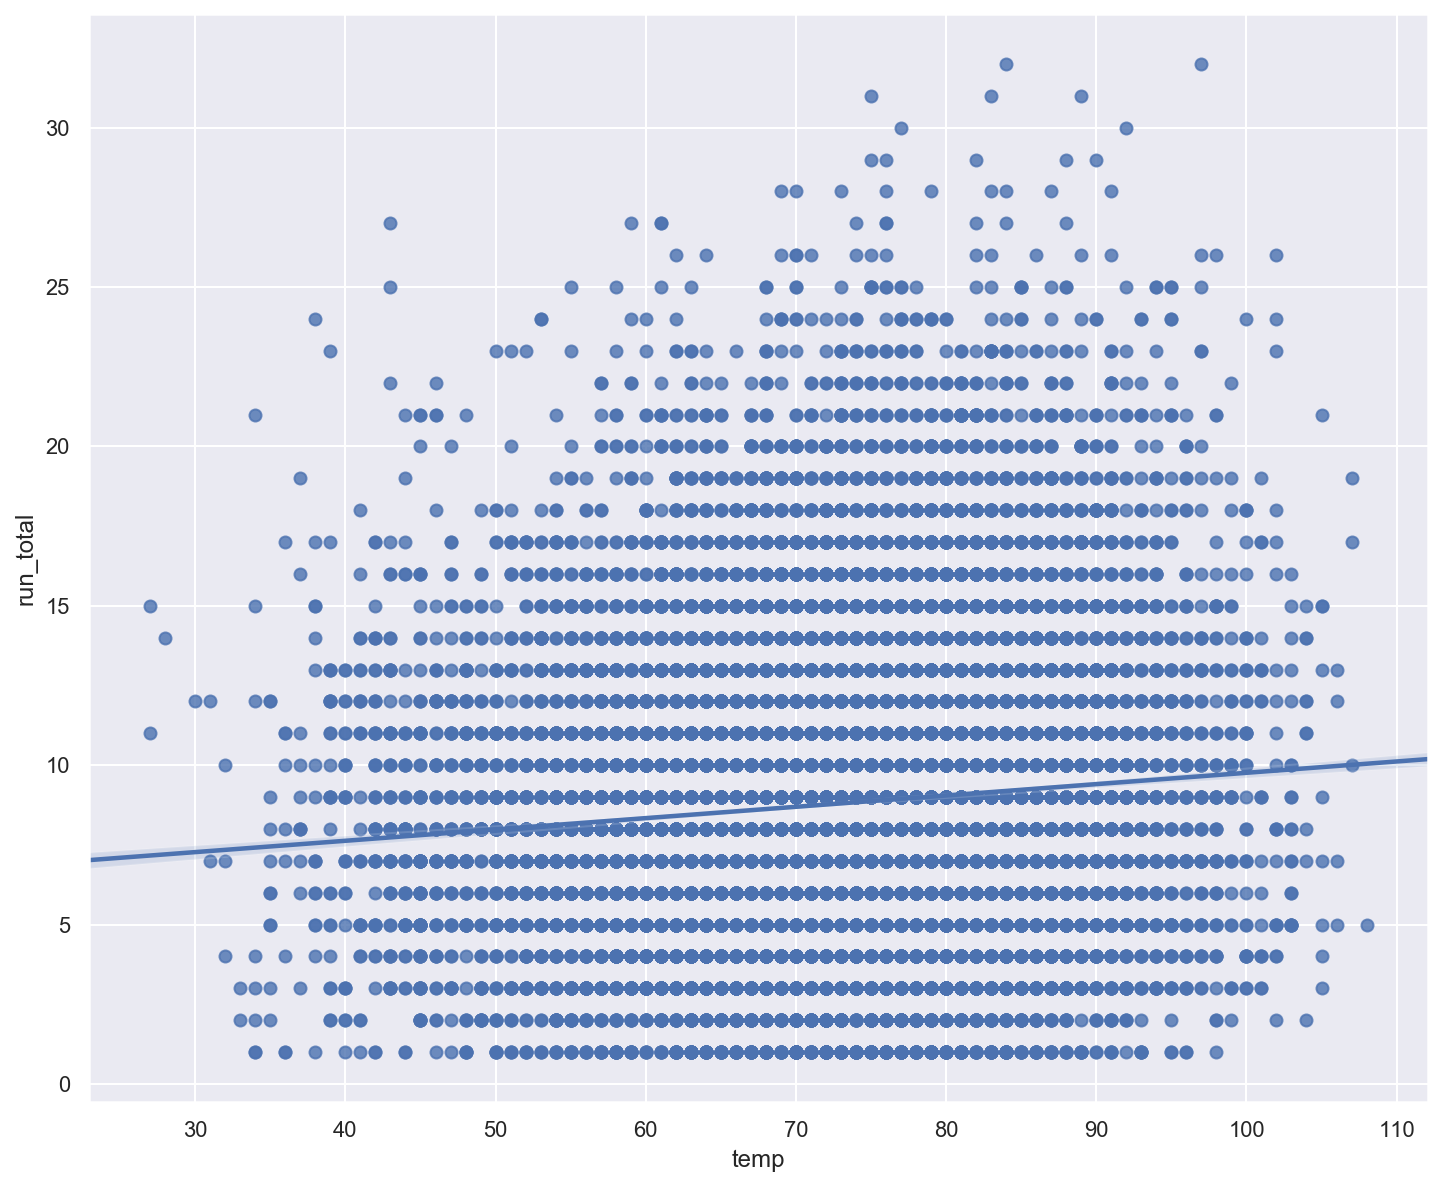

In [72]:
sns.regplot(df['temp'], df['run_total'])

In [32]:
temps = df['temp']
totals =df['run_total']

temp_std = np.std(temps)
total_std = np.std(totals)

temp_mean = np.mean(temps)
totals_mean = np.mean(totals)

temp_diff = temps - temp_mean
totals_diff = totals - totals_mean

covariance = np.sum(temp_diff * totals_diff)/len(totals_diff)
correl_coeff = covariance / (temp_std * total_std)

In [33]:
covariance, correl_coeff

(4.130196948298764, 0.08649813980708587)

In [34]:
temp_mean, totals_mean

(73.3386526843725, 8.811998936129791)

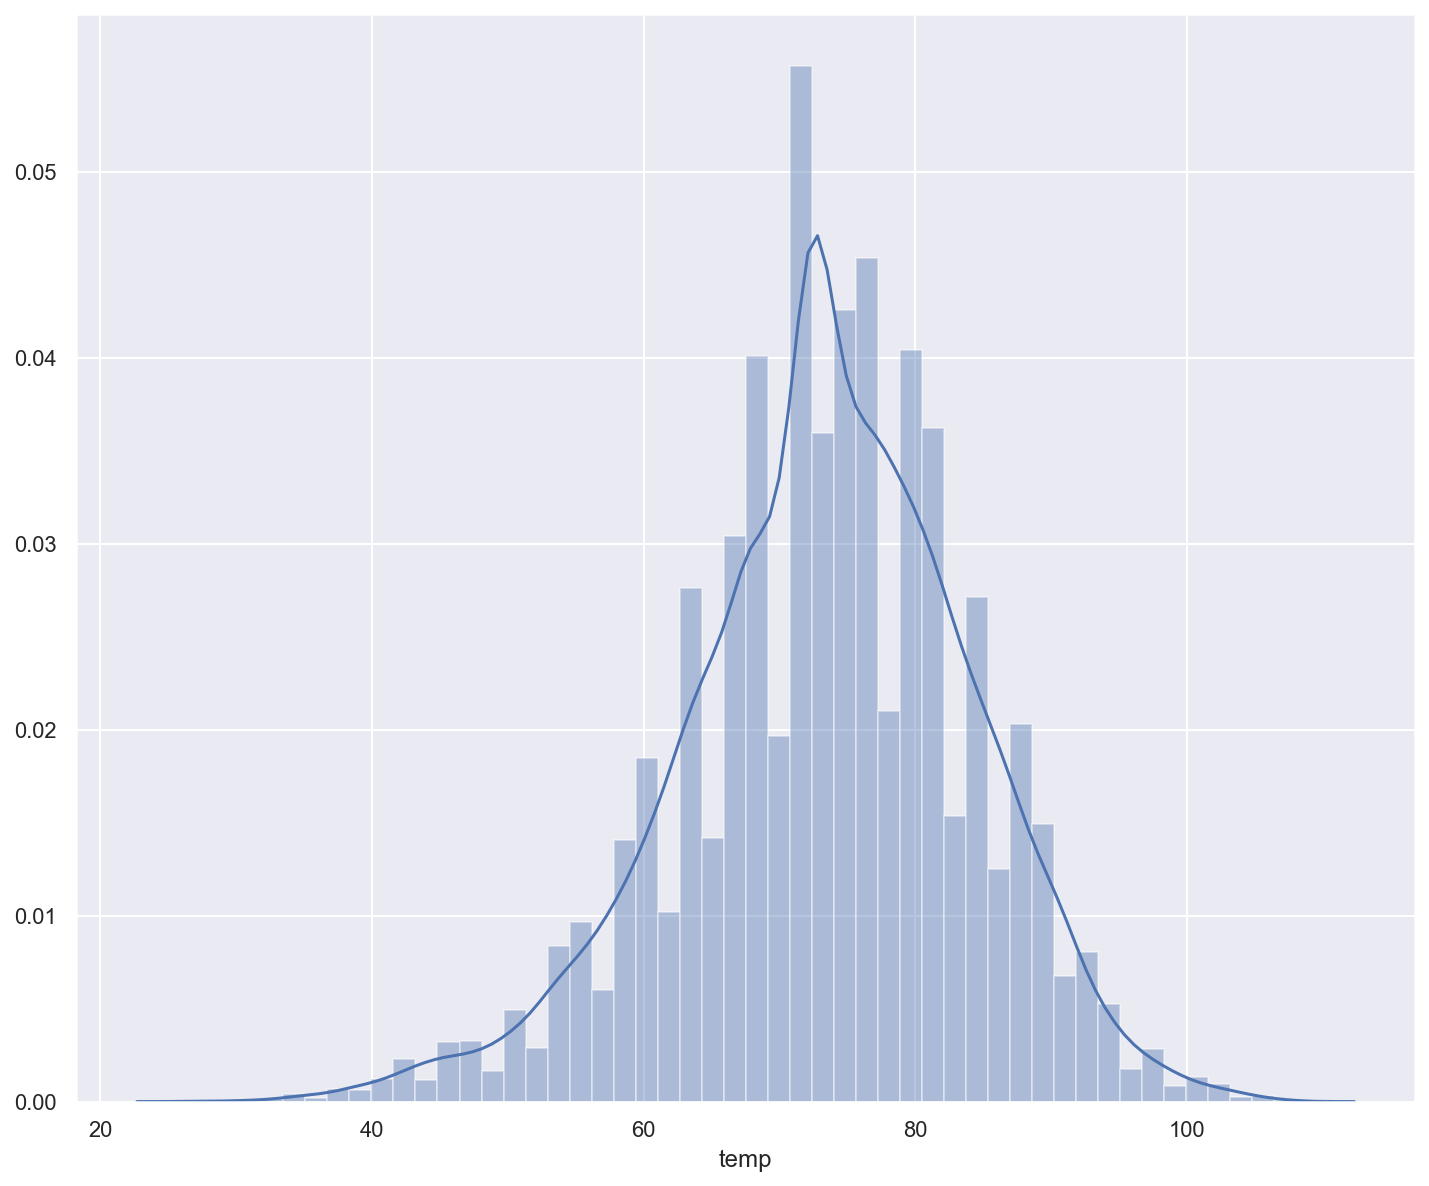

In [35]:
sns.distplot(temps)

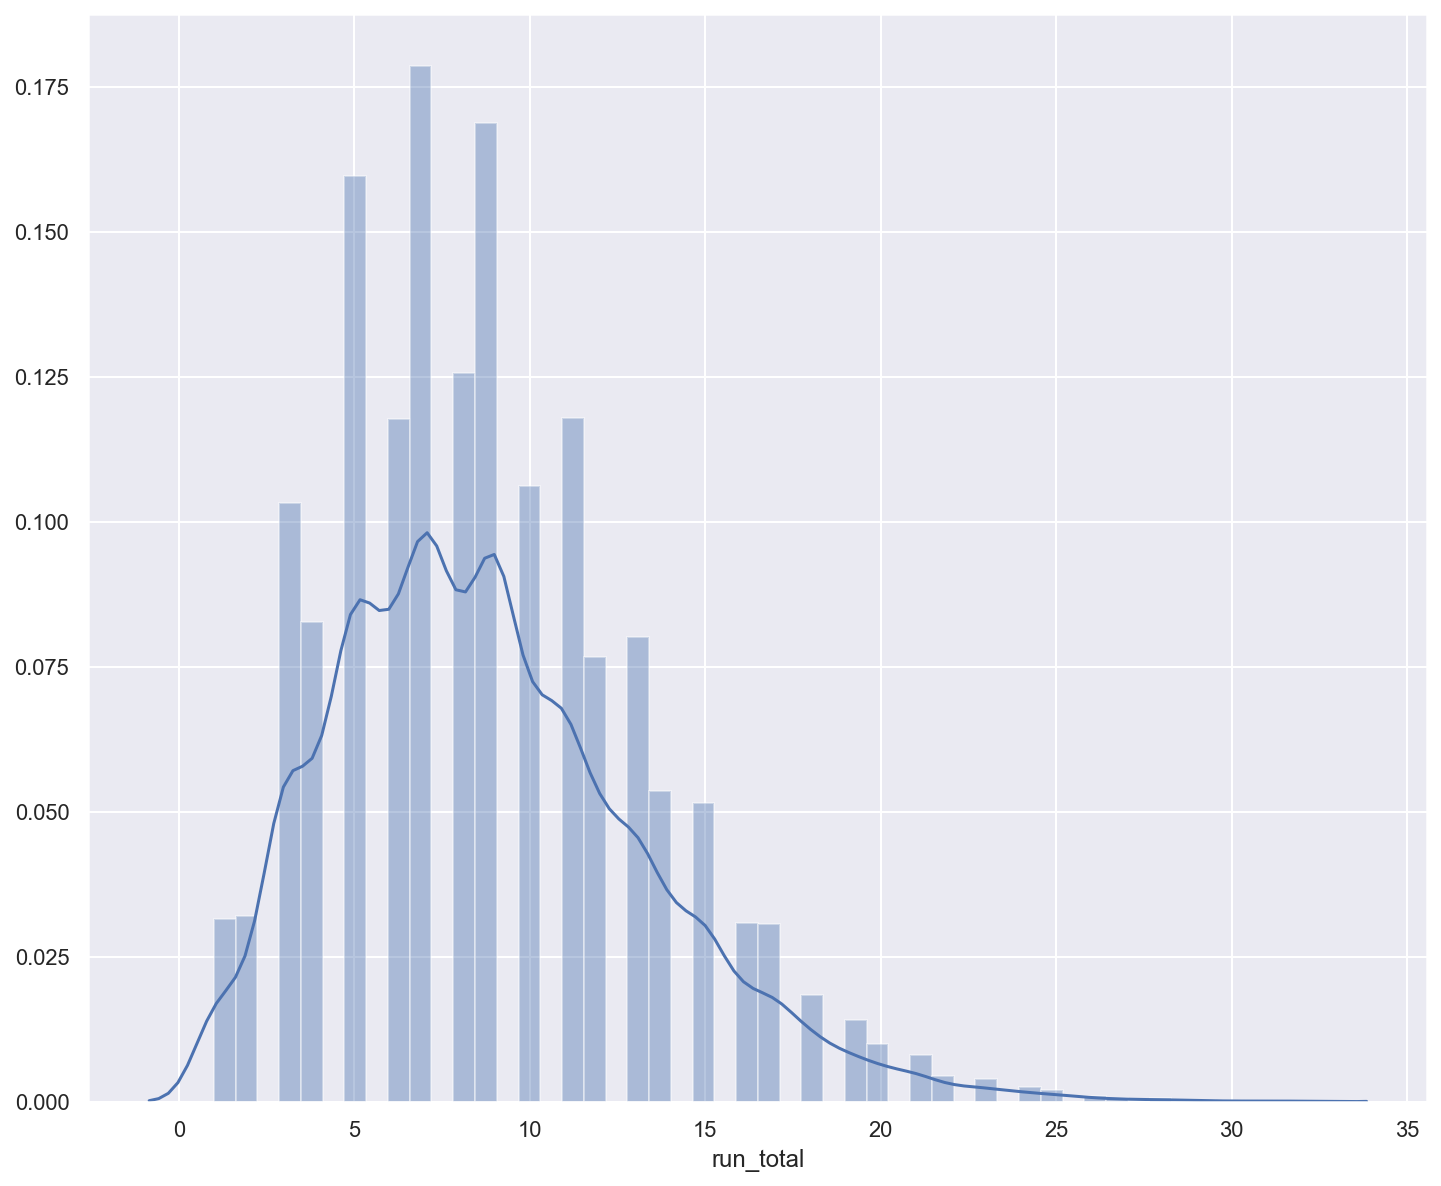

In [36]:
sns.distplot(totals)

In [37]:
scipy_regression = stats.linregress(temps, totals)
scipy_regression

LinregressResult(slope=0.03578296377796967, intercept=6.187724583599792, rvalue=0.08649813980709085, pvalue=6.842110171653001e-45, stderr=0.0025405079737964623)

In [82]:
model = sm.regression.linear_model.OLS(totals, temps)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              run_total   R-squared (uncentered):                   0.790
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                          9.928e+04
Date:                Thu, 14 Nov 2019   Prob (F-statistic):                        0.00
Time:                        19:07:40   Log-Likelihood:                         -77034.
No. Observations:               26319   AIC:                                  1.541e+05
Df Residuals:                   26318   BIC:                                  1.541e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.1184      0.000    315.093      0.000       0.118       0.119
==============================================================================
Omnibus:                     1876.249   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2346.714
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                       3.568   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Finally, we want to see how different stadiums effect runs scored.

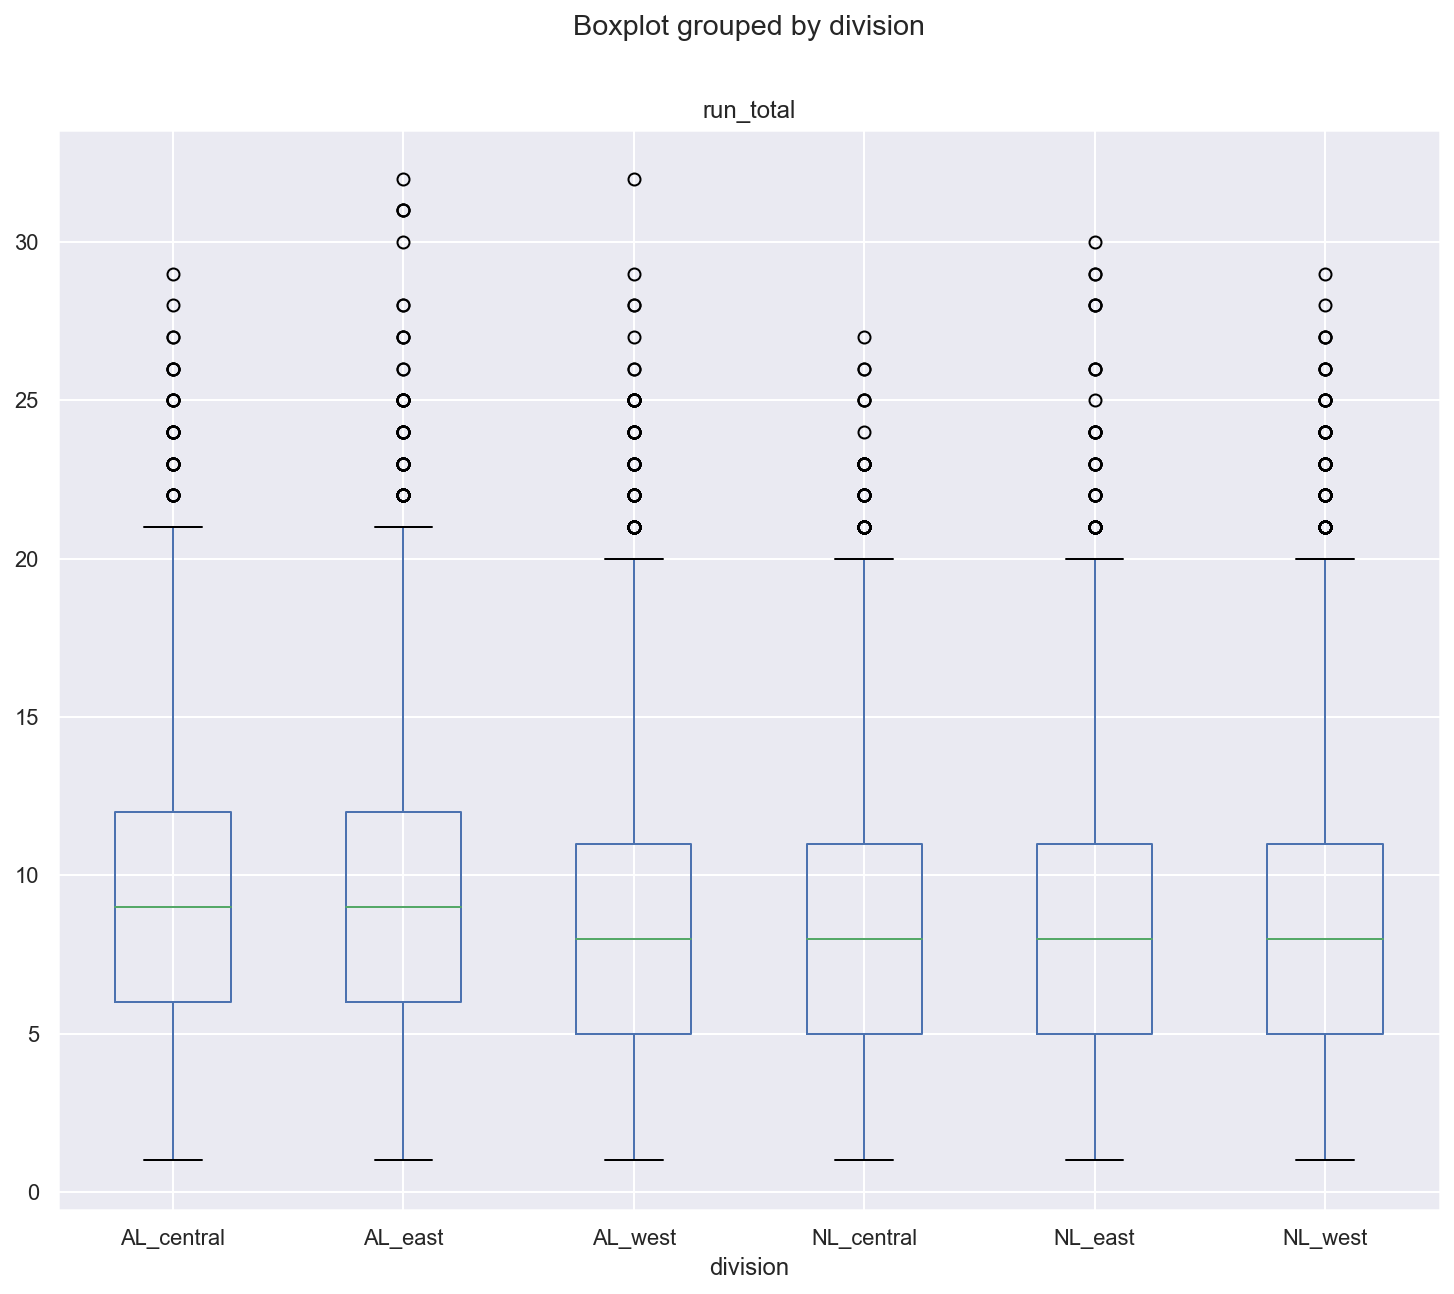

In [28]:
df.boxplot('run_total', by='division')

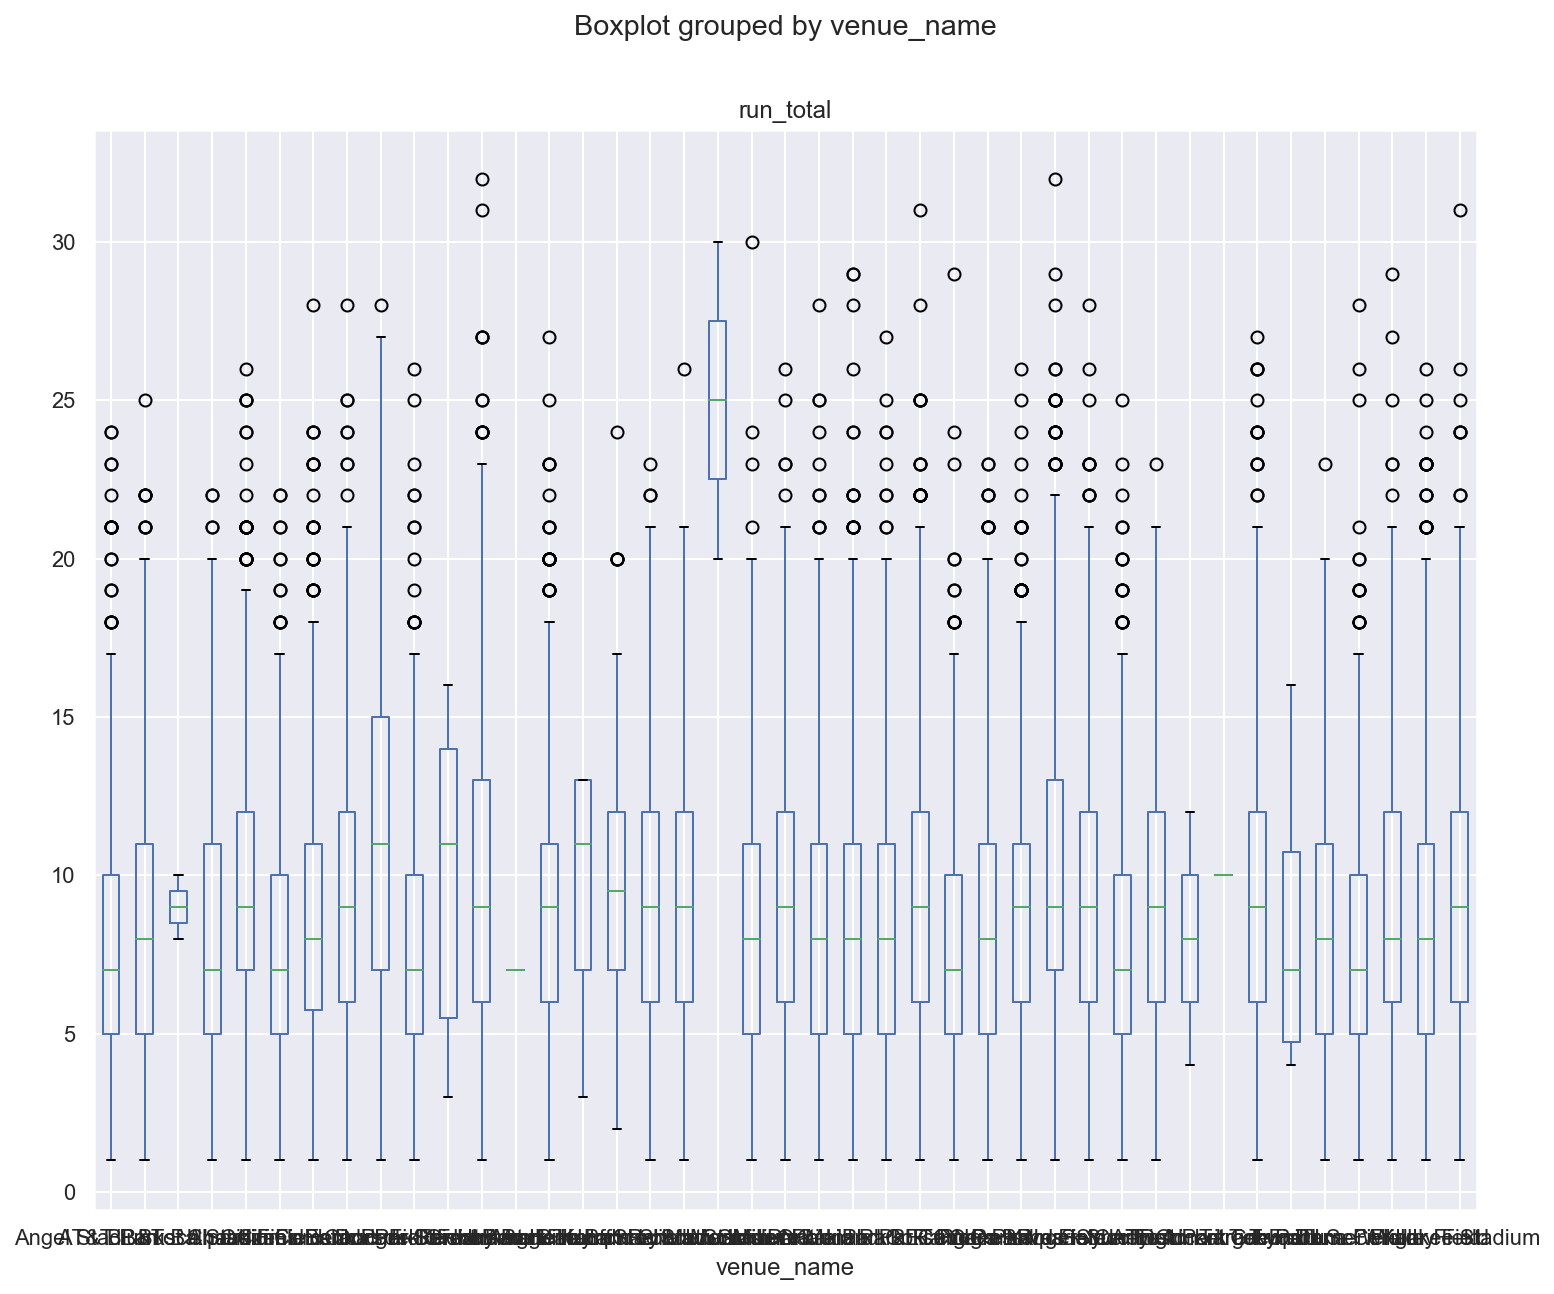

In [29]:
df.boxplot('run_total', by='venue_name')

In [30]:
formula = 'run_total ~ C(venue_name)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq       df          F         PR(>F)
C(venue_name)   17393.149212     40.0  22.739768  9.633545e-162
Residual       502486.621524  26278.0        NaN            NaN


In [85]:
df[df['division']=='AL_east']['venue_name'].unique()

array(['Rogers Centre', 'Oriole Park at Camden Yards', 'Fenway Park',
       'Tropicana Field', 'Yankee Stadium', 'Citizens Bank Park',
       'Citi Field', 'London Stadium'], dtype=object)